In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Environment Setup

This analysis was performed using Python in Google Colab due to the large size of the dataset (~6.3 million records).
Google Colab provides sufficient memory and compute resources to efficiently process large-scale data.


In [ ]:
from google.colab import files
files.upload()

Saving Fraud.csv to Fraud.csv
Buffered data was truncated after reaching the output size limit.

### Data Loading and Understanding

The dataset contains transactional data for a financial company.
Initial inspection was performed to understand the structure, data types, and overall size of the dataset.


In [7]:
import os
os.listdir('/content')

['.config', 'Fraud.csv', 'sample_data']

In [10]:
import pandas as pd

df = pd.read_csv('/content/Fraud.csv')


In [11]:
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Column Description

- step: Represents the time step of the transaction
- type: Type of transaction (TRANSFER, CASH_OUT, etc.)
- amount: Transaction amount
- oldbalanceOrg: Balance of origin account before transaction
- newbalanceOrig: Balance of origin account after transaction
- oldbalanceDest: Balance of destination account before transaction
- newbalanceDest: Balance of destination account after transaction
- isFraud: Target variable indicating fraudulent transactions
- isFlaggedFraud: Flag raised by existing system for potential fraud


In [12]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


### Data Cleaning

Missing value analysis showed no null values in the dataset.
Outliers were observed in transaction amounts; however, they were retained since fraudulent transactions often occur at extreme values.

Categorical variables were encoded, and multicollinearity was reduced by engineering balance difference features and removing redundant balance columns.


<Axes: xlabel='amount'>

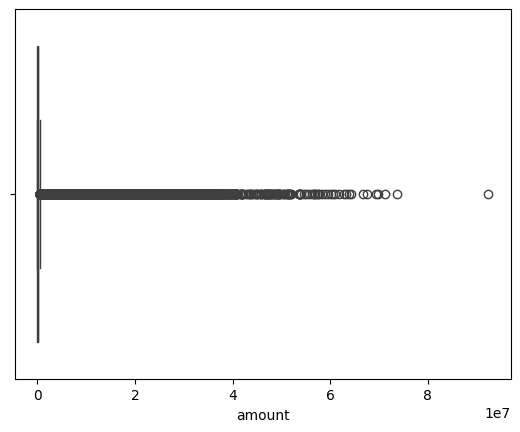

In [13]:
sns.boxplot(x=df['amount'])

In [14]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [15]:
df['orig_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

In [16]:
df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], axis=1, inplace=True)

In [17]:
df['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


### Exploratory Data Analysis

EDA revealed a strong class imbalance, with fraudulent transactions accounting for less than 1% of total transactions.
Fraud occurrences were predominantly observed in TRANSFER and CASH_OUT transaction types.


<Axes: xlabel='type_CASH_OUT', ylabel='count'>

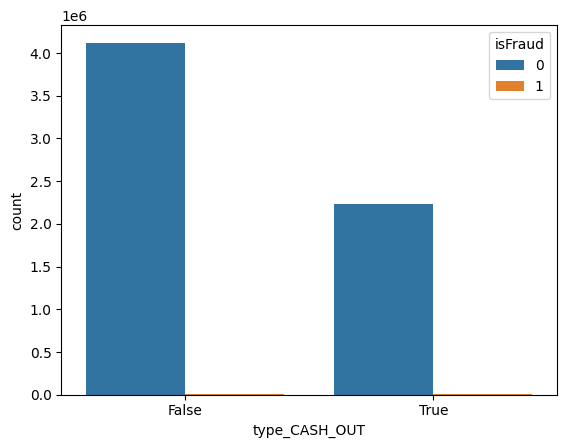

In [18]:
sns.countplot(x='type_CASH_OUT', hue='isFraud', data=df)

In [19]:
df.drop(['nameOrig','nameDest'], axis=1, inplace=True)

### Feature Selection

Features were selected based on domain understanding, correlation with the target variable, and model-based feature importance.
Identifier columns such as account names were removed as they do not contribute predictive value.


In [20]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Model Development

A Logistic Regression model was used as a baseline due to its interpretability.
A Random Forest model was selected as the primary model due to its ability to capture non-linear relationships, handle class imbalance, and provide feature importance insights.


In [22]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [23]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

In [24]:
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_prob)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.98      0.06      1643

    accuracy                           0.96   1272524
   macro avg       0.52      0.97      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524



np.float64(0.9972387659118865)

### Model Evaluation

Model performance was evaluated using precision, recall, F1-score, and ROC-AUC.
Recall was prioritized due to the high cost of missing fraudulent transactions.


Text(0.5, 1.0, 'ROC Curve')

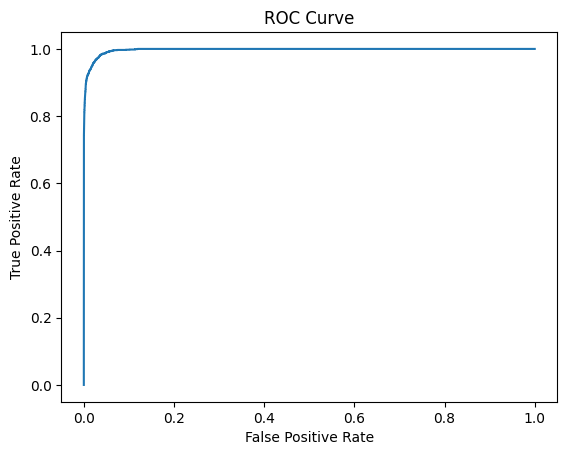

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [26]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)

,0
orig_balance_diff,0.510674
amount,0.153820
dest_balance_diff,0.104855
type_TRANSFER,0.096088
step,0.063035
type_PAYMENT,0.039167
type_CASH_OUT,0.029506
isFlaggedFraud,0.001914
type_DEBIT,0.000942


### Interpretation of Key Fraud Predictors

The identified fraud predictors are logical from a business perspective.
Fraudulent transactions often involve large transaction amounts, occur during TRANSFER or CASH_OUT operations, and result in abnormal balance changes.
These patterns align with known fraudulent behaviors where attackers attempt to rapidly drain funds.


### Fraud Prevention Recommendations

- Implement real-time transaction monitoring systems
- Apply stricter verification for high-value and high-risk transactions
- Introduce two-factor authentication for suspicious transfers
- Use behavioral analysis and transaction velocity checks


### Measuring Effectiveness of Prevention Measures

The effectiveness of implemented fraud controls can be measured through:
- Reduction in financial losses due to fraud
- Improved recall of fraud detection models
- Lower false positive rates
- Reduction in manual transaction reviews
